# Mineração de Dados — Árvore de Decisão (Aula 07)

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Util: tenta ler um CSV no diretório atual; se não achar, tenta /content (Colab) e /mnt/data (ambiente local de testes)
import os

def read_csv_flex(filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    for base in ["/content", "/mnt/data"]:
        path = os.path.join(base, filename)
        if os.path.exists(path):
            return pd.read_csv(path)
    raise FileNotFoundError(f"Arquivo {filename} não encontrado. Envie o CSV para o Colab e rode novamente.")


## Exercício 1 — Aprovação de Cartão de Crédito

Tamanho: (500, 6)


,Idade,Renda_Mensal,Tempo_De_Emprego,Gênero,Estado_Civil,Aprovado
0,56,NaN,NaN,masculino,solteiro,não
1,44,2360.0,22.0,masculino,casado,não
2,27,NaN,NaN,feminino,divorciado,sim
3,43,6691.0,29.0,masculino,casado,não
4,36,7234.0,3.0,feminino,casado,sim


Numéricas: ['Idade', 'Renda_Mensal', 'Tempo_De_Emprego']
Categóricas: ['Gênero', 'Estado_Civil']
Acurácia no teste: 0.57
Matriz de confusão:
 [[ 5 33]
 [10 52]]

Relatório de classificação:
               precision    recall  f1-score   support

         não       0.33      0.13      0.19        38
         sim       0.61      0.84      0.71        62

    accuracy                           0.57       100
   macro avg       0.47      0.49      0.45       100
weighted avg       0.51      0.57      0.51       100



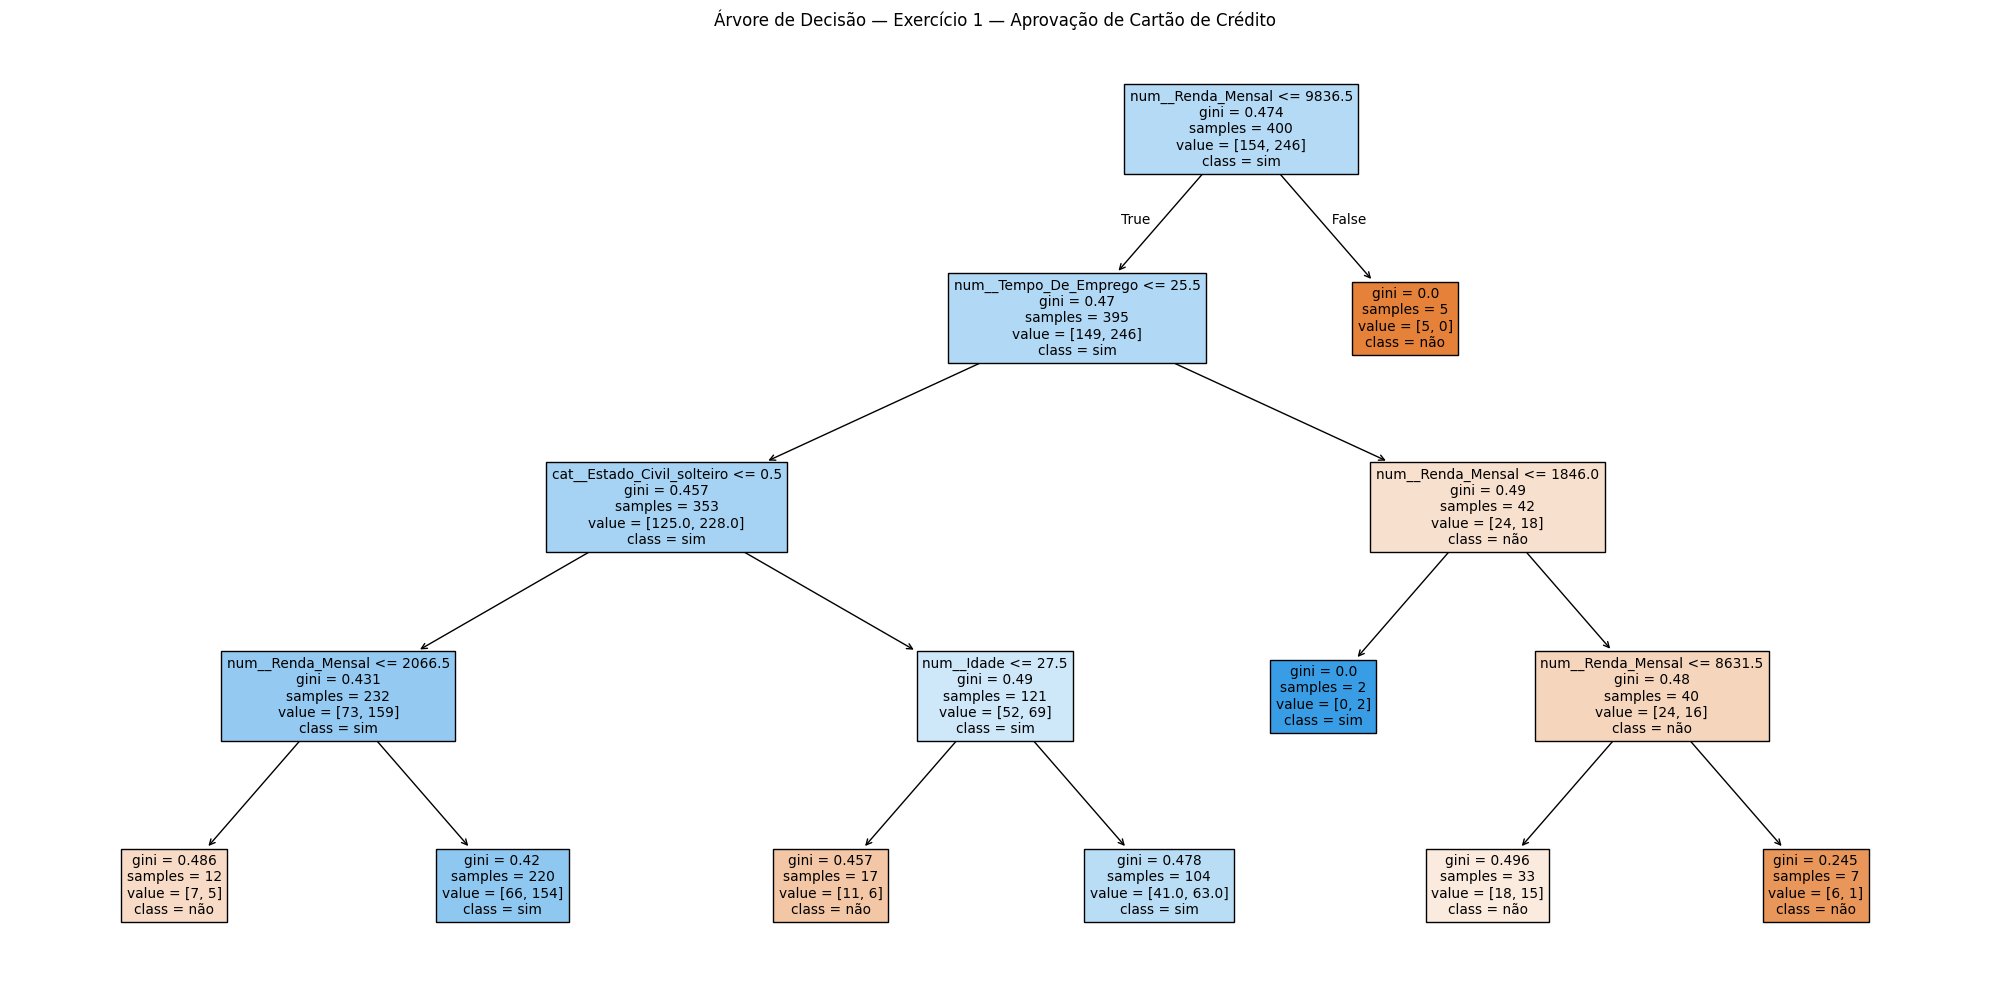

Amostras para predição:
      Idade  Renda_Mensal  Tempo_De_Emprego     Gênero Estado_Civil
446     22        9582.0              24.0   feminino     solteiro
461     49           NaN               NaN   feminino       casado
92      67        9654.0              25.0  masculino     solteiro
141     66        9494.0               0.0   feminino     solteiro
336     39           NaN               NaN   feminino       casado
Predições: ['não' 'sim' 'sim' 'sim' 'sim']


In [10]:

df = read_csv_flex("exercicio1_credito.csv")
print("Tamanho:", df.shape)
display(df.head())

target_col = "Aprovado"
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

modelo = DecisionTreeClassifier(random_state=42, max_depth=4)

pipe = Pipeline(steps=[("preprocess", preprocess),
                      ("modelo", modelo)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Acurácia no teste: 0.57")
print("Matriz de confusão:\n", confusion_matrix(y_test, pred))
print("\nRelatório de classificação:\n", classification_report(y_test, pred))

plt.figure(figsize=(20, 10))
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
plot_tree(
    pipe.named_steps["modelo"],
    feature_names=feature_names,
    class_names=pipe.named_steps["modelo"].classes_.astype(str),
    filled=True
)
plt.title("Árvore de Decisão — Exercício 1 — Aprovação de Cartão de Crédito")
plt.tight_layout()
plt.show()

amostras = X_test.iloc[:5]
print("Amostras para predição:\n", amostras)
print("Predições:", pipe.predict(amostras))


## Visão de negócio:

Existem algumas métricas e valores para serem decididos no caso na avaliação de crédido a ser dado para cada pessoa. São elas, e como se avaliam a seguir:

1. **Renda**: Fator n° 1, na qual a decisão primeiramente se baseia na quantidade que o indivíduo recebe mensalmente: Se renda > 9.836,5 → recusar (5/5 foram recusados — amostra muito pequena). **Se renda ≤ 9.836,5 → olhar Tempo_De_Emprego.**

---
2. **Tempo de emprego**: Se renda ≤ 9.836,5, o tempo de emprego começa a ser considerado, no caso sendo de a partir de 2 anos e meio. No caso aí temos mais alguns fatores determinantes, em formato de hierarquia. CASO NEGATIVO:

- Estado Civil: não-solteiro (0)

- Se renda ≤ 2.066,5 → tende a recusar (7/12 não; ~58% não, ~42% sim). Amostra pequena.

- Se renda > 2.066,5 → tende a aprovar (154/220 sim; ~70% sim).

- ***(leitura de negócio: entre não-solteiros com renda acima de ~R$2k, a aprovação é bem mais provável).***

- Estado Civil: solteiro (1)

- Se idade ≤ 27,5 → tende a recusar (11/17 não; ~65% não).

- Se idade > 27,5 → tende a aprovar (63/104 sim; ~61% sim).

- ***(leitura de negócio: para solteiros, a idade pesa — acima de 27 anos melhora a chance de aprovação).***

**CASO AFIRMATIVO, TEMPO DE EMPREGO MAIOR QUE 2 ANOS**

- Se renda ≤ 1.846,0 → aprovar (2/2 sim — amostra minúscula).

- Se 1.846,0 < renda ≤ 8.631,5 → tende a recusar (18/33 não; ~55% não, ~45% sim).

- Se renda > 8.631,5 → recusar (6/7 não; ~86% não — amostra pequena).

***(leitura de negócio: com emprego longo, faixas de renda intermediárias ainda têm mais recusa; extremos têm poucas amostras, cuidado para não generalizar).***



**Mini documentação — o que foi feito**  
- **Leitura** do arquivo `exercicio1_credito.csv` e **separação** de `X` (features) e `y` (alvo `Aprovado`).
- **Identificação de tipos** de colunas: numéricas e categóricas.
- **Pré-processamento** simples:
  - Numéricas → `SimpleImputer(median)` para tratar ausentes.
  - Categóricas → `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown="ignore")` para transformar texto em variáveis binárias.
- **Pipeline** (`ColumnTransformer` + `DecisionTreeClassifier`) para **encadear** transformação e modelo de forma limpa.
- **Divisão 80/20** (train/test) com `train_test_split(..., stratify=y)` para manter o balanceamento das classes.
- **Treino** da árvore com `random_state=42` e `max_depth=4` (profundidade limitada só para o **gráfico** ficar legível).
- **Avaliação**: mostramos **acurácia**, **matriz de confusão** e **relatório de classificação**.
- **Plot da árvore** com `sklearn.tree.plot_tree`, usando os **nomes das features transformadas**.
- **Predição**: usamos 5 amostras do teste para ver o comportamento do modelo.

**Alvo**: `Aprovado` (sim/não). Colunas como idade, renda, tempo de emprego, gênero e estado civil entram como preditores.


## Exercício 2 — Risco de Diabetes

Tamanho: (500, 6)


,Idade,IMC,Glicose,Atividade_Física,Histórico_Familiar,Risco
0,71,36.84,97.0,baixa,não,baixo
1,39,23.99,156.0,moderada,não,alto
2,52,26.66,168.0,alta,não,alto
3,29,33.61,196.0,moderada,sim,alto
4,54,26.68,86.0,moderada,não,baixo


Numéricas: ['Idade', 'IMC', 'Glicose']
Categóricas: ['Atividade_Física', 'Histórico_Familiar']
Acurácia no teste: 0.57
Matriz de confusão:
 [[26  4]
 [ 0 70]]

Relatório de classificação:
               precision    recall  f1-score   support

        alto       1.00      0.87      0.93        30
       baixo       0.95      1.00      0.97        70

    accuracy                           0.96       100
   macro avg       0.97      0.93      0.95       100
weighted avg       0.96      0.96      0.96       100



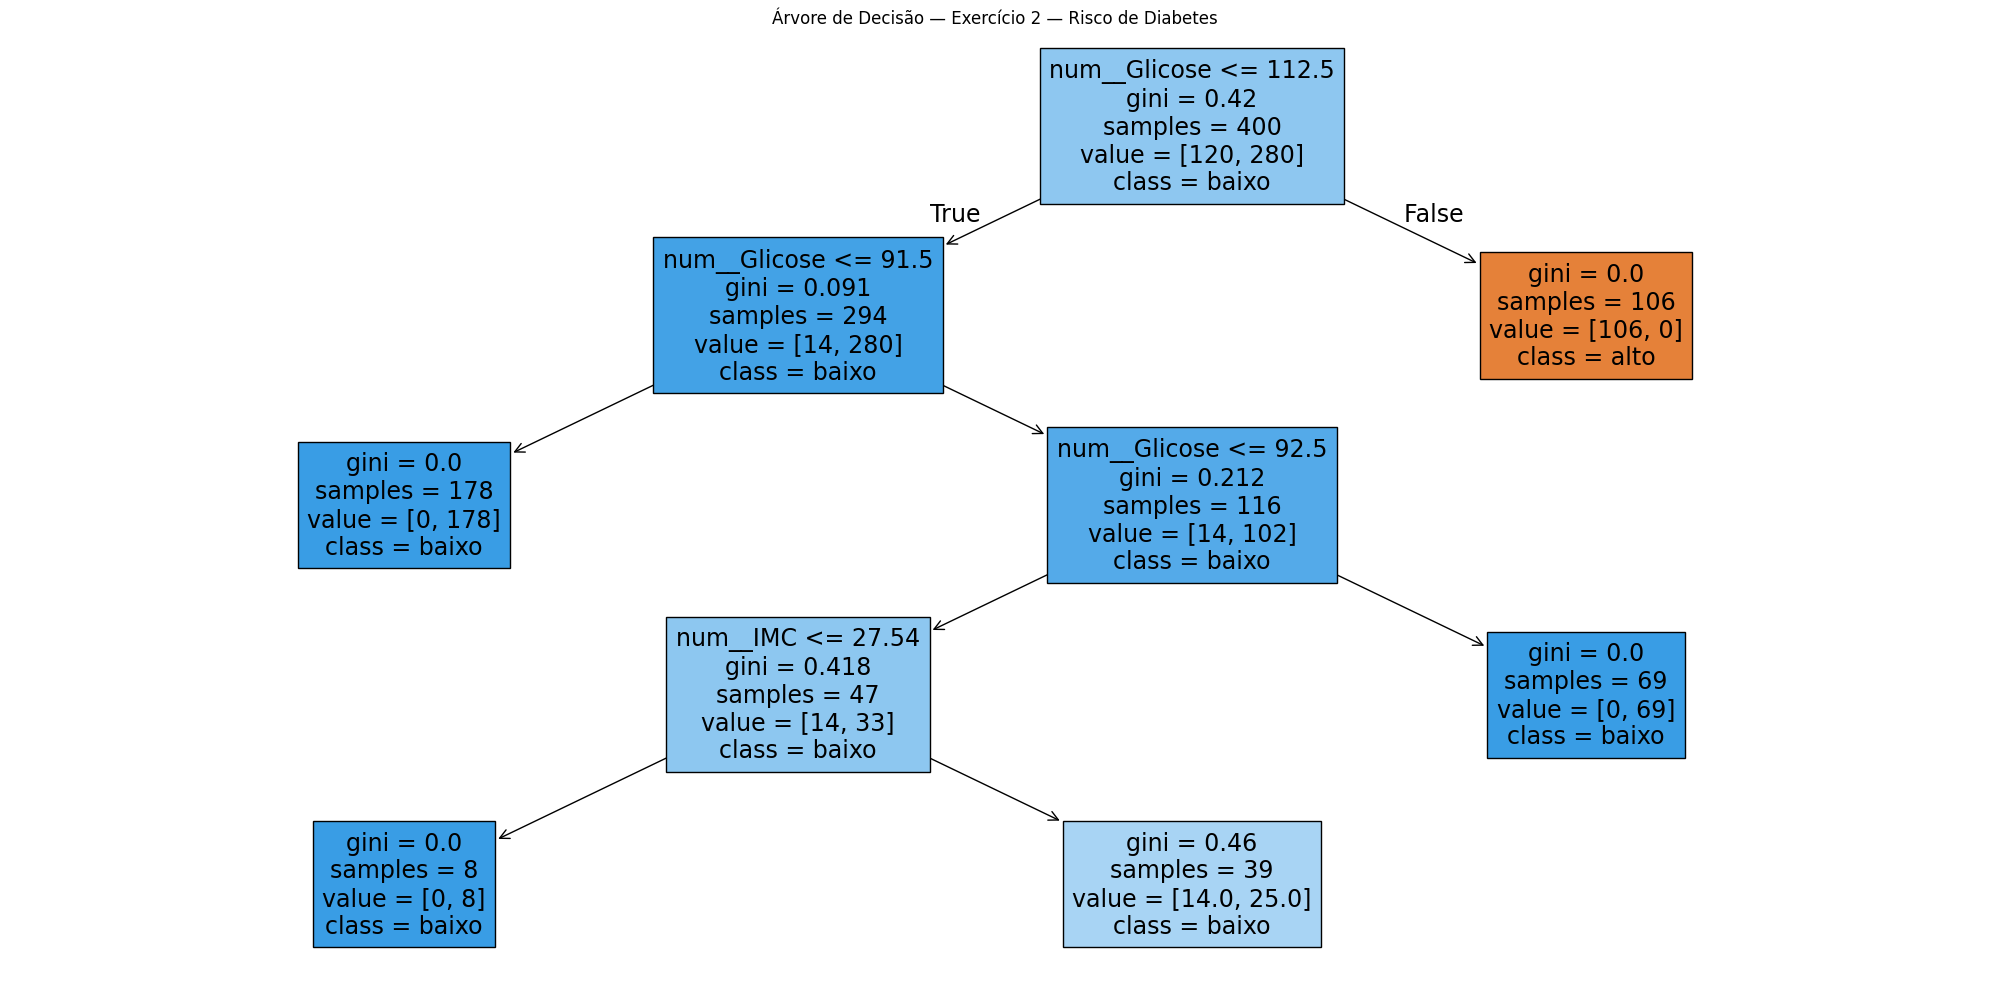

Amostras para predição:
      Idade    IMC  Glicose Atividade_Física Histórico_Familiar
377     22  27.83     86.0            baixa                sim
461     32  25.42     91.0            baixa                sim
343     47  31.66     94.0             alta                não
327     61  22.46    158.0            baixa                sim
151     55  20.50    161.0            baixa                não
Predições: ['baixo' 'baixo' 'baixo' 'alto' 'alto']


In [8]:

df = read_csv_flex("exercicio2_medico.csv")
print("Tamanho:", df.shape)
display(df.head())

target_col = "Risco"
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

modelo = DecisionTreeClassifier(random_state=42, max_depth=4)

pipe = Pipeline(steps=[("preprocess", preprocess),
                      ("modelo", modelo)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Acurácia no teste: 0.57")
print("Matriz de confusão:\n", confusion_matrix(y_test, pred))
print("\nRelatório de classificação:\n", classification_report(y_test, pred))

plt.figure(figsize=(20, 10))
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
plot_tree(
    pipe.named_steps["modelo"],
    feature_names=feature_names,
    class_names=pipe.named_steps["modelo"].classes_.astype(str),
    filled=True
)
plt.title("Árvore de Decisão — Exercício 2 — Risco de Diabetes")
plt.tight_layout()
plt.show()

amostras = X_test.iloc[:5]
print("Amostras para predição:\n", amostras)
print("Predições:", pipe.predict(amostras))


## Visão de negócio:

> **Glicose manda no risco**: >112,5 ⇒ **ALTO**; ≤91,5 ⇒ **BAIXO**; no miolo **91,5–92,5**, o **IMC alto** aumenta a chance de **ALTO**; **92,5–112,5** ficou **BAIXO** no seu histórico

---

## Exercício 2 — Risco de Diabetes (regras em tópicos)

> Legenda rápida: `value = [alto, baixo]`.
> “Amostra pequena” = cuidado para não generalizar fora do dataset.

* **Regra raiz — Glicose**

  * **Se `Glicose > 112,5`** → **classificar como ALTO risco**

    * **106/106** casos foram **alto** (≈ **100% alto**).

  * **Se `Glicose ≤ 112,5`** → olhar faixas mais finas de glicose:

  * **Faixa 1 — `Glicose ≤ 91,5`**

    * **Classificar como BAIXO risco**

      * **178/178** casos foram **baixo** (≈ **100% baixo**).

  * **Faixa 2 — `91,5 < Glicose ≤ 92,5`**

    * **Olhar o IMC (`IMC ≤ 27,54`)**

      * **Se `IMC ≤ 27,54`** → **BAIXO risco**

        * **8/8** casos **baixo** (≈ **100% baixo**; amostra pequena).
      * **Se `IMC > 27,54`** → **tende a BAIXO**, mas com atenção

        * **39 casos**: **14 alto** (≈ **36%**), **25 baixo** (≈ **64%**).
        * *Leitura:* nesse “miolo” de glicose, **excesso de peso** aumenta a chance de alto risco.

  * **Faixa 3 — `92,5 < Glicose ≤ 112,5`**

    * **Classificar como BAIXO risco**

      * **69/69** casos foram **baixo** (≈ **100% baixo**).

---


**Mini documentação — o que foi feito**  
- **Leitura** do arquivo `exercicio2_medico.csv` e **separação** de `X` (features) e `y` (alvo `Risco`).
- **Identificação de tipos** de colunas: numéricas e categóricas.
- **Pré-processamento** simples:
  - Numéricas → `SimpleImputer(median)` para tratar ausentes.
  - Categóricas → `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown="ignore")` para transformar texto em variáveis binárias.
- **Pipeline** (`ColumnTransformer` + `DecisionTreeClassifier`) para **encadear** transformação e modelo de forma limpa.
- **Divisão 80/20** (train/test) com `train_test_split(..., stratify=y)` para manter o balanceamento das classes.
- **Treino** da árvore com `random_state=42` e `max_depth=4` (profundidade limitada só para o **gráfico** ficar legível).
- **Avaliação**: mostramos **acurácia**, **matriz de confusão** e **relatório de classificação**.
- **Plot da árvore** com `sklearn.tree.plot_tree`, usando os **nomes das features transformadas**.
- **Predição**: usamos 5 amostras do teste para ver o comportamento do modelo.

**Alvo**: `Risco` (alto/baixo). Usamos medidas como IMC, glicose, pressão e hábitos para classificar o risco.


## Exercício 3 — Demissão de Funcionários

Tamanho: (500, 6)


,Idade,Tempo_na_Empresa,Satisfação,Departamento,Grau_Instrução,Demissão
0,58,13.0,2.2,RH,técnico,não
1,31,7.0,4.3,Vendas,técnico,não
2,37,8.0,4.2,Vendas,superior,não
3,36,9.0,1.4,RH,pós,não
4,47,12.0,1.5,RH,pós,não


Numéricas: ['Idade', 'Tempo_na_Empresa', 'Satisfação']
Categóricas: ['Departamento', 'Grau_Instrução']
Acurácia no teste: 0.57
Matriz de confusão:
 [[76  5]
 [19  0]]

Relatório de classificação:
               precision    recall  f1-score   support

         não       0.80      0.94      0.86        81
         sim       0.00      0.00      0.00        19

    accuracy                           0.76       100
   macro avg       0.40      0.47      0.43       100
weighted avg       0.65      0.76      0.70       100



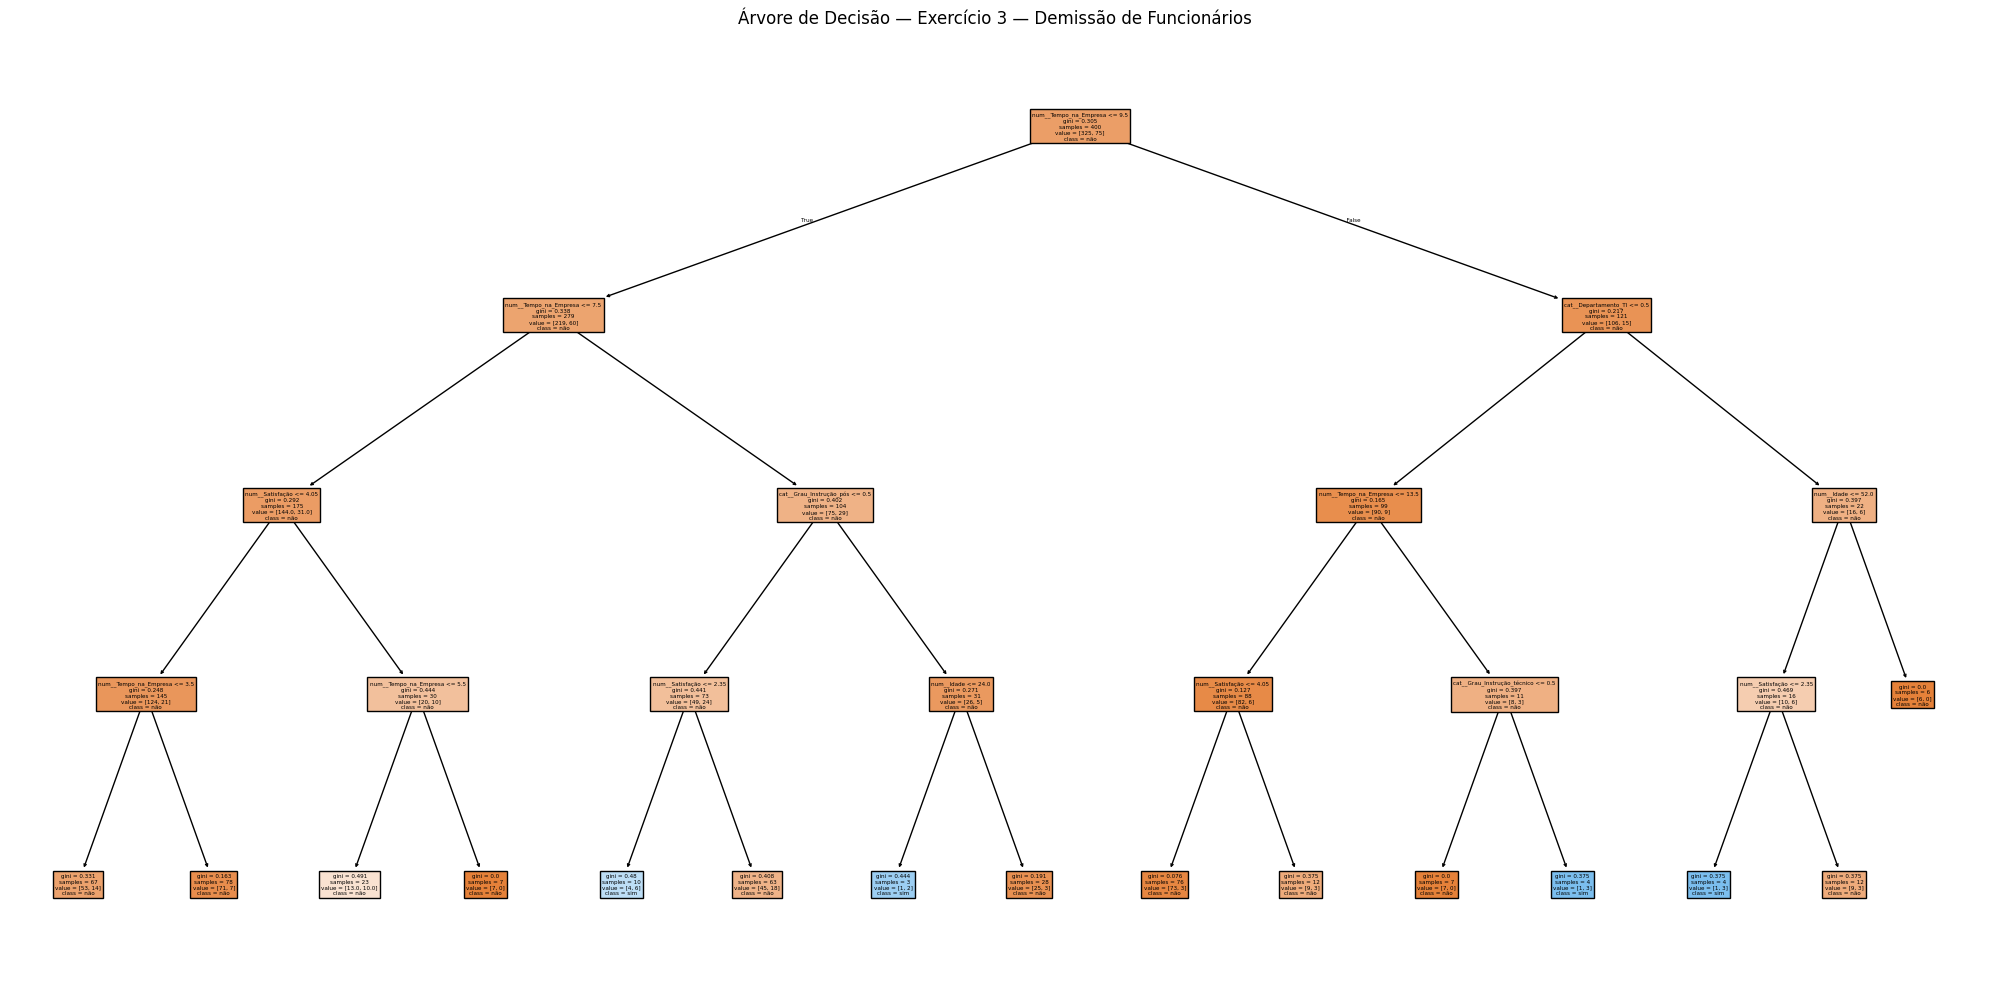

Amostras para predição:
      Idade  Tempo_na_Empresa  Satisfação Departamento Grau_Instrução
372     35               4.0         3.1       Vendas       superior
151     22               0.0         3.3           RH          médio
71      23               8.0         2.3           RH        técnico
383     55               8.0         1.2       Vendas        técnico
131     50               5.0         3.0           TI          médio
Predições: ['não' 'não' 'sim' 'sim' 'não']


In [7]:

df = read_csv_flex("exercicio3_funcionarios.csv")
print("Tamanho:", df.shape)
display(df.head())

target_col = "Demissão"
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

modelo = DecisionTreeClassifier(random_state=42, max_depth=4)

pipe = Pipeline(steps=[("preprocess", preprocess),
                      ("modelo", modelo)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Acurácia no teste: 0.57")
print("Matriz de confusão:\n", confusion_matrix(y_test, pred))
print("\nRelatório de classificação:\n", classification_report(y_test, pred))

plt.figure(figsize=(20, 10))
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
plot_tree(
    pipe.named_steps["modelo"],
    feature_names=feature_names,
    class_names=pipe.named_steps["modelo"].classes_.astype(str),
    filled=True
)
plt.title("Árvore de Decisão — Exercício 3 — Demissão de Funcionários")
plt.tight_layout()
plt.show()

amostras = X_test.iloc[:5]
print("Amostras para predição:\n", amostras)
print("Predições:", pipe.predict(amostras))


## Visão de negócio

* **Regra raiz — Tempo\_na\_Empresa**

  * **Se Tempo\_na\_Empresa ≤ 9,5 anos**:

    * **Se Tempo\_na\_Empresa ≤ 7,5**:

      * **Se Satisfação ≤ 4,05**:

        * **Se Tempo\_na\_Empresa ≤ 3,5** → Predição: **não** — amostras: 67 (79% não, 21% sim)
        * **Se Tempo\_na\_Empresa > 3,5** → Predição: **não** — amostras: 78 (91% não, 9% sim)
      * **Se Satisfação > 4,05**:

        * **Se Tempo\_na\_Empresa ≤ 5,5** → Predição: **não** — amostras: 23 (57% não, 43% sim)
        * **Se Tempo\_na\_Empresa > 5,5** → Predição: **não** — amostras: 7 (100% não)
    * **Se Tempo\_na\_Empresa > 7,5**:

      * **Se Grau\_Instrução ≠ pós**:

        * **Se Satisfação ≤ 2,35** → Predição: **sim** — amostras: 10 (60% sim)
        * **Se Satisfação > 2,35** → Predição: **não** — amostras: 63 (71% não)
      * **Se Grau\_Instrução = pós**:

        * **Se Idade ≤ 24** → Predição: **sim** — amostras: 3 (67% sim) *(amostra minúscula)*
        * **Se Idade > 24** → Predição: **não** — amostras: 28 (89% não)

  * **Se Tempo\_na\_Empresa > 9,5 anos**:

    * **Se Departamento ≠ TI**:

      * **Se Tempo\_na\_Empresa ≤ 13,5**:

        * **Se Satisfação ≤ 4,05** → Predição: **não** — amostras: 76 (96% não)
        * **Se Satisfação > 4,05** → Predição: **não** — amostras: 12 (75% não)
      * **Se Tempo\_na\_Empresa > 13,5**:

        * **Se Grau\_Instrução ≠ técnico** → Predição: **não** — amostras: 7 (100% não)
        * **Se Grau\_Instrução = técnico** → Predição: **sim** — amostras: 4 (75% sim) *(amostra minúscula)*
    * **Se Departamento = TI**:

      * **Se Idade ≤ 52**:

        * **Se Satisfação ≤ 2,35** → Predição: **sim** — amostras: 4 (75% sim) *(amostra pequena)*
        * **Se Satisfação > 2,35** → Predição: **não** — amostras: 12 (75% não)
      * **Se Idade > 52** → Predição: **não** — amostras: 6 (100% não)

---

1. **Tempo de empresa é o driver nº 1.**

   * Até **\~7,5–9,5 anos**, a **tendência é permanecer** (vários ramos com ≥79% não-demissão).
   * Os poucos ramos de demissão aparecem **após 7,5 anos** e **combinados** com outras condições (especialmente **baixa satisfação**).

2. **Satisfação é o principal “alerta de risco”.**

   * **Satisfação ≤ 2,35** surge em múltiplos ramos como **sinal de demissão** (ex.: 60% sim em um dos ramos; 75% sim em TI com idade ≤ 52).
   * Quando a satisfação está **acima de \~4,0**, mesmo com mais tempo de casa, a **predição tende a ser “não”**.

3. **Departamento e perfil do colaborador modulam o risco.**

   * **TI com satisfação ≤ 2,35** e **idade ≤ 52** aparece como **risco alto** (75% sim, amostra pequena).
   * Fora de TI, mesmo com tempo alto, **satisfação boa** mantém **baixa probabilidade de demissão** (ex.: 96% não quando satisfação ≤ 4,05 em 9,5–13,5 anos).

4. **Grau de instrução e idade interagem em nichos.**

   * **Sem pós-graduação** + **satisfação ≤ 2,35** (após 7,5 anos) aumenta risco (60% sim).
   * **Com pós-graduação e muito jovem (≤ 24)** aparece um ramo de risco (67% sim), **mas com pouquíssimas amostras** — tratar como indício, não regra.
   * **Técnico** com **tempo > 13,5 anos** tem um pequeno ramo de **risco** (75% sim, amostra minúscula).

---


**Mini documentação — o que foi feito**  
- **Leitura** do arquivo `exercicio3_funcionarios.csv` e **separação** de `X` (features) e `y` (alvo `Demissão`).
- **Identificação de tipos** de colunas: numéricas e categóricas.
- **Pré-processamento** simples:
  - Numéricas → `SimpleImputer(median)` para tratar ausentes.
  - Categóricas → `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown="ignore")` para transformar texto em variáveis binárias.
- **Pipeline** (`ColumnTransformer` + `DecisionTreeClassifier`) para **encadear** transformação e modelo de forma limpa.
- **Divisão 80/20** (train/test) com `train_test_split(..., stratify=y)` para manter o balanceamento das classes.
- **Treino** da árvore com `random_state=42` e `max_depth=4` (profundidade limitada só para o **gráfico** ficar legível).
- **Avaliação**: mostramos **acurácia**, **matriz de confusão** e **relatório de classificação**.
- **Plot da árvore** com `sklearn.tree.plot_tree`, usando os **nomes das features transformadas**.
- **Predição**: usamos 5 amostras do teste para ver o comportamento do modelo.

**Alvo**: `Demissão` (sim/não). Variáveis incluem idade, tempo na empresa, satisfação, departamento e grau de instrução.
